In [1]:
import os
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import median_absolute_error
# Global settings

warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run.

## Reading ctraw data

In [22]:
data = pd.read_csv('ctraw011024_stripped.csv')
print(f'Shape of X= {data.shape}')
data.head()

Shape of X= (30453, 24)


,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PLAN_CT,PKG_CODE,TESTER,BU,TESTERTYPE,...,WASHOLD,HOLDREASONS,PLAN_CT_100PERC1D,OEEFACTOR,OEEFACTORSRC,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS,QUEUE_DAYS,HOLIDAY_HRS
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,0.692132,W20#H2,MAV1064,NaN,MAV1,...,0,NaN,1.408358,0.590000,CPT_HIST,MO78A-0A,SOIC (W),0.877431,NaN,NaN
1,87-1374C#333,43724,4.8409,P45775_WIP,0.0,2.376148,W16#H2,MAV1064,NaN,MAV1,...,0,NaN,2.401927,0.590000,CPT_HIST,MO52A-0A,SOIC (W),2.071620,NaN,NaN
2,87-1374C#333,26421,3.9700,P45775_WIP,0.0,1.442703,W16#H2,MAV1064,NaN,MAV1,...,0,NaN,1.851195,0.590000,CPT_EXACT,MO52A-0A,SOIC (W),1.484132,NaN,NaN
3,87-1340C#RX3,18679,1.7869,P45775_WIP,0.0,1.071639,W16#H2,MAV1064,NaN,MAV1,...,0,NaN,1.632267,0.590000,CPT_EXACT,MO87A-0A,SOIC (W),0.522847,NaN,NaN
4,MAX1480AEPI+,8940,10.0325,1HHR_HYBE_WIP,0.0,4.047827,P28M+1,KTS098,NaN,KTS,...,0,NaN,2.216064,0.300424,CPT_HIST,RT15P-3,PDIP HYBRID,1.692477,NaN,NaN


In [31]:

sample_data = {'PART_NUMBER': '89-32KHZ#S08', 'TRANSACTION_QTY': 10804, 'ACT_CT': 23.2013, 'ROUTE': 'P41421_WIP', 'HOLD_DAYS': 0.0, 'PLAN_CT': 0.692132082, 'PKG_CODE': 'W20#H2', 'TESTER': 'MAV1064', 'BU': "nan", 'TESTERTYPE': 'MAV1', 'EXCLUDE_FLAG': 'NONTESTFLOW', 'PLAN_CT_100PERC': 0.408357928, 'TESTSTEPCNT': 3.0, 'PLAN_CT_100PERC2H1D': 1.658357928, 'WASHOLD': 0, 'HOLDREASONS': "nan", 'PLAN_CT_100PERC1D': 1.408357928, 'OEEFACTOR': 0.59, 'OEEFACTORSRC': 'CPT_HIST', 'DIETYPE': 'MO78A-0A', 'PACKAGETYPE': 'SOIC (W)', 'DOWNTIME_DAYS': 0.877430556}
input_data = pd.DataFrame([sample_data])
input_data

,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PLAN_CT,PKG_CODE,TESTER,BU,TESTERTYPE,...,TESTSTEPCNT,PLAN_CT_100PERC2H1D,WASHOLD,HOLDREASONS,PLAN_CT_100PERC1D,OEEFACTOR,OEEFACTORSRC,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,0.692132,W20#H2,MAV1064,nan,MAV1,...,3.0,1.658358,0,nan,1.408358,0.59,CPT_HIST,MO78A-0A,SOIC (W),0.877431


## Data Preprocessing

In [3]:
# # Specify the columns to drop
# columns_to_drop = ['QUEUE_DAYS', 'HOLIDAY_HRS', 'HOLDREASONS', "BU", "EXCLUDE_FLAG", "OEEFACTORSRC","OEEFACTOR", "PLAN_CT_100PERC1D","PLAN_CT_100PERC2H1D","PLAN_CT_100PERC", "PLAN_CT", "TESTSTEPCNT"]

# # Drop specified columns
# data.drop(columns=columns_to_drop, inplace=True)
data = data[["PART_NUMBER","TRANSACTION_QTY","ACT_CT",
            "ROUTE","HOLD_DAYS","PKG_CODE","TESTER",
            "TESTERTYPE","WASHOLD","DIETYPE","PACKAGETYPE",
            "DOWNTIME_DAYS"]]
data.head()

,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PKG_CODE,TESTER,TESTERTYPE,WASHOLD,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,W20#H2,MAV1064,MAV1,0,MO78A-0A,SOIC (W),0.877431
1,87-1374C#333,43724,4.8409,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO52A-0A,SOIC (W),2.071620
2,87-1374C#333,26421,3.9700,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO52A-0A,SOIC (W),1.484132
3,87-1340C#RX3,18679,1.7869,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO87A-0A,SOIC (W),0.522847
4,MAX1480AEPI+,8940,10.0325,1HHR_HYBE_WIP,0.0,P28M+1,KTS098,KTS,0,RT15P-3,PDIP HYBRID,1.692477


In [4]:
# Specify the columns to check for null values
columns_to_check = ['ACT_CT']#, 'column2', 'column3']

# Drop rows with null values in specified columns
data.dropna(subset=columns_to_check, inplace=True)
data.head()

,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PKG_CODE,TESTER,TESTERTYPE,WASHOLD,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,W20#H2,MAV1064,MAV1,0,MO78A-0A,SOIC (W),0.877431
1,87-1374C#333,43724,4.8409,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO52A-0A,SOIC (W),2.071620
2,87-1374C#333,26421,3.9700,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO52A-0A,SOIC (W),1.484132
3,87-1340C#RX3,18679,1.7869,P45775_WIP,0.0,W16#H2,MAV1064,MAV1,0,MO87A-0A,SOIC (W),0.522847
4,MAX1480AEPI+,8940,10.0325,1HHR_HYBE_WIP,0.0,P28M+1,KTS098,KTS,0,RT15P-3,PDIP HYBRID,1.692477


In [5]:
#check NA values
for col in data.columns:
    if any(data[col].isna()):    
        print(f"{col}: {data[col].isna().value_counts()}")

PKG_CODE: PKG_CODE
False    30451
True         2
Name: count, dtype: int64
TESTER: TESTER
False    30452
True         1
Name: count, dtype: int64
TESTERTYPE: TESTERTYPE
False    30452
True         1
Name: count, dtype: int64
PACKAGETYPE: PACKAGETYPE
False    30409
True        44
Name: count, dtype: int64


In [6]:
print(data.dtypes)

PART_NUMBER         object
TRANSACTION_QTY      int64
ACT_CT             float64
ROUTE               object
HOLD_DAYS          float64
PKG_CODE            object
TESTER              object
TESTERTYPE          object
WASHOLD              int64
DIETYPE             object
PACKAGETYPE         object
DOWNTIME_DAYS      float64
dtype: object


In [7]:
#Fill all NA with frequent values.
for col in data.columns:
    if any(data[col].isna()):    
        freq_val = data[col].mode()[0]
        data[col].fillna(freq_val, inplace=True)

In [8]:
for col in data.columns:
    print(data[col].value_counts())

PART_NUMBER
MAX17845ACB/V+CJT    548
MAX17854ACB/V+       459
MAX96717FGTJ/VY+     360
90-29020#340         318
MAX77597ETBB+T       281
                    ... 
MAX33014EATB+          1
MAX14611ETD+T          1
MAX16133HPB/V+         1
MAX705MJA/883B         1
MAX9725AETC+           1
Name: count, Length: 3808, dtype: int64
TRANSACTION_QTY
20000    102
34300     92
5000      91
10000     89
15000     88
        ... 
9673       1
1043       1
10263      1
10229      1
55462      1
Name: count, Length: 22601, dtype: int64
ACT_CT
1.2276     6
1.2141     6
1.3009     5
1.0434     5
1.4369     5
          ..
1.0885     1
0.3843     1
0.3826     1
1.7858     1
15.3290    1
Name: count, Length: 25276, dtype: int64
ROUTE
6_R_WIP                      1414
SPREVCLD_A_WIP               1157
6_SOT_HV_WIP                 1079
P45775_WIP                   1040
4_RH_A_WIP                    954
                             ... 
SWR_PH-23-0552-3_TECN_WIP       1
4_ML_WIP                        1
SWR_

## Data Preprocessing

In [9]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encodings = {}
        
    def fit(self, X, y):
        # Ensure columns to encode are specified
        if self.columns is None:
            self.columns = X.select_dtypes(include=['object']).columns
        
        # Compute target means for each category in each column
        for col in self.columns:
            encoding = X.groupby(col)[y.name].mean()
            self.encodings[col] = encoding
        return self
    
    def transform(self, X):
        X_new = X.copy()
        # Apply the encodings to X
        for col, encoding in self.encodings.items():
            X_new[col] = X_new[col].map(encoding).fillna(X_new[col])
        return X_new

In [10]:
# Custom transformer for applying pd.get_dummies
class DummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, dtype=float):
        self.columns = columns
        self.dtype = dtype
        
    def fit(self, X, y=None):
        return self  # Nothing to fit
    
    def transform(self, X):
        # Applying pd.get_dummies to the specified columns
        return pd.get_dummies(X, columns=self.columns, dtype=self.dtype)

# Custom function for transforming HOLD_DAYS
def add_hold_days_category(X):
    X_new = X.copy()  # Copy to avoid changing the original data
    X_new['HOLD_DAYS_CATEGORY'] = (X_new['HOLD_DAYS'] != 0).astype(int)
    return X_new

In [11]:
# Instantiate the custom transformers
dummies_transformer = DummiesTransformer(columns=['WASHOLD', 'TESTERTYPE'])
hold_days_transformer = FunctionTransformer(add_hold_days_category)

In [12]:
# Create the pipeline
pipeline = Pipeline(steps=[
    ('dummies', dummies_transformer),
    ('hold_days_category', hold_days_transformer)
])

In [13]:
df = pipeline.fit_transform(data)
len(df.columns)

38

In [62]:
#input data as single row
df1 = data.iloc[0].to_frame().transpose()
df1

,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PKG_CODE,TESTER,TESTERTYPE,WASHOLD,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,W20#H2,MAV1064,MAV1,0,MO78A-0A,SOIC (W),0.877431


In [69]:
df2 = pipeline.fit_transform(df1)
df2

,PART_NUMBER,TRANSACTION_QTY,ACT_CT,ROUTE,HOLD_DAYS,PKG_CODE,TESTER,DIETYPE,PACKAGETYPE,DOWNTIME_DAYS,WASHOLD_0,TESTERTYPE_MAV1,HOLD_DAYS_CATEGORY
0,89-32KHZ#S08,10804,23.2013,P41421_WIP,0.0,W20#H2,MAV1064,MO78A-0A,SOIC (W),0.877431,1.0,1.0,0


In [14]:
X = df.drop(columns="ACT_CT")
y = df["ACT_CT"]

In [15]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')


In [16]:
X.dtypes

PART_NUMBER             category
TRANSACTION_QTY            int64
ROUTE                   category
HOLD_DAYS                float64
PKG_CODE                category
TESTER                  category
DIETYPE                 category
PACKAGETYPE             category
DOWNTIME_DAYS            float64
WASHOLD_0                float64
WASHOLD_1                float64
TESTERTYPE_ASL1K         float64
TESTERTYPE_ASL3K         float64
TESTERTYPE_ASL4K         float64
TESTERTYPE_DOT400        float64
TESTERTYPE_DUO           float64
TESTERTYPE_EAGLE88       float64
TESTERTYPE_HP            float64
TESTERTYPE_KTS           float64
TESTERTYPE_KVDM2         float64
TESTERTYPE_LTX           float64
TESTERTYPE_LTXMX         float64
TESTERTYPE_MAV1          float64
TESTERTYPE_MAV2          float64
TESTERTYPE_MICROFLEX     float64
TESTERTYPE_NOISE         float64
TESTERTYPE_QUARTET       float64
TESTERTYPE_RFX           float64
TESTERTYPE_SC212         float64
TESTERTYPE_STS5020       float64
TESTERTYPE

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state = random_state)

In [36]:
print(list(X_train.columns))

['PART_NUMBER', 'TRANSACTION_QTY', 'ROUTE', 'HOLD_DAYS', 'PKG_CODE', 'TESTER', 'DIETYPE', 'PACKAGETYPE', 'DOWNTIME_DAYS', 'WASHOLD_0', 'WASHOLD_1', 'TESTERTYPE_ASL1K', 'TESTERTYPE_ASL3K', 'TESTERTYPE_ASL4K', 'TESTERTYPE_DOT400', 'TESTERTYPE_DUO', 'TESTERTYPE_EAGLE88', 'TESTERTYPE_HP', 'TESTERTYPE_KTS', 'TESTERTYPE_KVDM2', 'TESTERTYPE_LTX', 'TESTERTYPE_LTXMX', 'TESTERTYPE_MAV1', 'TESTERTYPE_MAV2', 'TESTERTYPE_MICROFLEX', 'TESTERTYPE_NOISE', 'TESTERTYPE_QUARTET', 'TESTERTYPE_RFX', 'TESTERTYPE_SC212', 'TESTERTYPE_STS5020', 'TESTERTYPE_SZ', 'TESTERTYPE_TERA360Z', 'TESTERTYPE_TERCAT', 'TESTERTYPE_TERFLEX', 'TESTERTYPE_TERJ750', 'TESTERTYPE_TERMAG2', 'HOLD_DAYS_CATEGORY']


In [92]:
models_scores = [] # To store model scores

def median_ae(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return median_absolute_error(y_test, y_pred) # Returns Median Absolute Error

# Parameter Optimization

In [ ]:
import optuna
#xgboost
def objective(trial):
    # Hyperparameters to be tuned
    param = {
        'enable_categorical': True,
        'verbosity': 0,
        'objective': 'reg:squarederror',  # Use 'reg:logistic' for classification tasks
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'gamma': trial.suggest_float('gamma', 0.0, 0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 2),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 0.9),
        'subsample': trial.suggest_float('subsample', 0.5, 0.6),
        
    }
    
    # Initialize XGBoost model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    
    # Predict and calculate median absolute error
    y_pred = model.predict(X_test)
    error = median_absolute_error(y_test, y_pred)
    
    return error

# Assuming X_train, X_test, y_train, y_test are already defined
# Create a study object and perform optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)  # Adjust n_trials according to your computational budget

# Output the best hyperparameters
print('Best trial:', study.best_trial.params)

Best trial xgb: {'colsample_bytree': 0.5566986718192767, 'gamma': 0.0649178474096254, 'learning_rate': 0.019047849061702475, 'max_depth': 7, 'min_child_weight': 1.614624079796953, 'n_estimators': 2225, 'reg_alpha': 0.48132195855349247, 'reg_lambda': 0.817151106790412, 'subsample': 0.5675734074009705}
score: 0.6786791843414306.

In [ ]:
#gradient Boosting
def objective_gb(trial):
    # Specifying the hyperparameter space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'loss': trial.suggest_categorical('loss', ['ls', 'lad', 'huber', 'quantile']),
        'random_state': 42  # Ensure reproducibility
    }

    # Creating the model with the specified parameters
    model = GradientBoostingRegressor(**param)
    model.fit(X_train, y_train)
    
    # Predicting and calculating the median absolute error
    y_pred = model.predict(X_test)
    error = median_absolute_error(y_test, y_pred)
    
    return error

# Creating the study and optimizing
study = optuna.create_study(direction='minimize')
study.optimize(objective_gb, n_trials=10)  # Adjust the number of trials as necessary

# Outputting the best parameters
print('Best trial GB:', study.best_trial.params)

In [ ]:
def objective_lgb(trial):
    # Hyperparameters to be tuned
    param = {
        'objective': 'regression',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_bin': trial.suggest_int('max_bin', 20, 255),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.9),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 100),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 100),
        'random_state': 42,  # Ensure reproducibility
        'bagging_seed': 9,  # Fixed seed for bagging
        'feature_fraction_seed': 9,  # Fixed seed for feature fraction
    }

    # Creating the model with the specified parameters
    model = lgb.LGBMRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    # Predicting and calculating the median absolute error
    y_pred = model.predict(X_test)
    error = median_absolute_error(y_test, y_pred)
    
    return error

# Creating the study and optimizing
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgb, n_trials=100)  # Adjust the number of trials as necessary

# Outputting the best parameters
print('Best trial LGBM:', study.best_trial.params)

Best trial LGBM: {'num_leaves': 120, 'learning_rate': 0.019054657412190056, 'n_estimators': 201, 'max_bin': 46, 'bagging_fraction': 0.6743734897831135, 'bagging_freq': 2, 'feature_fraction': 0.8984122708261087, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 84.00072081453929}
score: 0.6229418778919118.

## Final Training with cross validations for best params

In [65]:
from sklearn.model_selection import cross_val_score, KFold
# Initialize XGBoost model with best parameters
best_params_xgb = {'enable_categorical':True, 'colsample_bytree': 0.5566986718192767, 'gamma': 0.0649178474096254, 'learning_rate': 0.019047849061702475, 'max_depth': 7, 'min_child_weight': 1.614624079796953, 'n_estimators': 2225, 'reg_alpha': 0.48132195855349247, 'reg_lambda': 0.817151106790412, 'subsample': 0.5675734074009705}
model_xgb = xgb.XGBRegressor(**best_params_xgb)

# Define a 5-fold cross-validation configuration
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation and calculate the mean absolute error
# Replace 'neg_median_absolute_error' with another scoring metric if desired
scores = cross_val_score(model_xgb, X, y, scoring='neg_median_absolute_error', cv=kf, n_jobs=-1)

# Convert scores to positive; cross_val_score returns negative values for 'neg_*' metrics to maximize them
median_absolute_errors = -scores

print(f"Median Absolute Errors for each fold: {median_absolute_errors}")
print(f"Mean Median Absolute Error: {np.mean(median_absolute_errors)}")

Median Absolute Errors for each fold: [0.83501777 0.78119586 0.78815504 0.80570376 0.81300333]
Mean Median Absolute Error: 0.8046151524639129


In [67]:
from joblib import load, dump
model_xgb = xgb.XGBRegressor(**best_params_xgb)
model_xgb.fit(X,y)
dump(model_xgb, 'xgboost_model.pkl')

['xgboost_model.pkl']

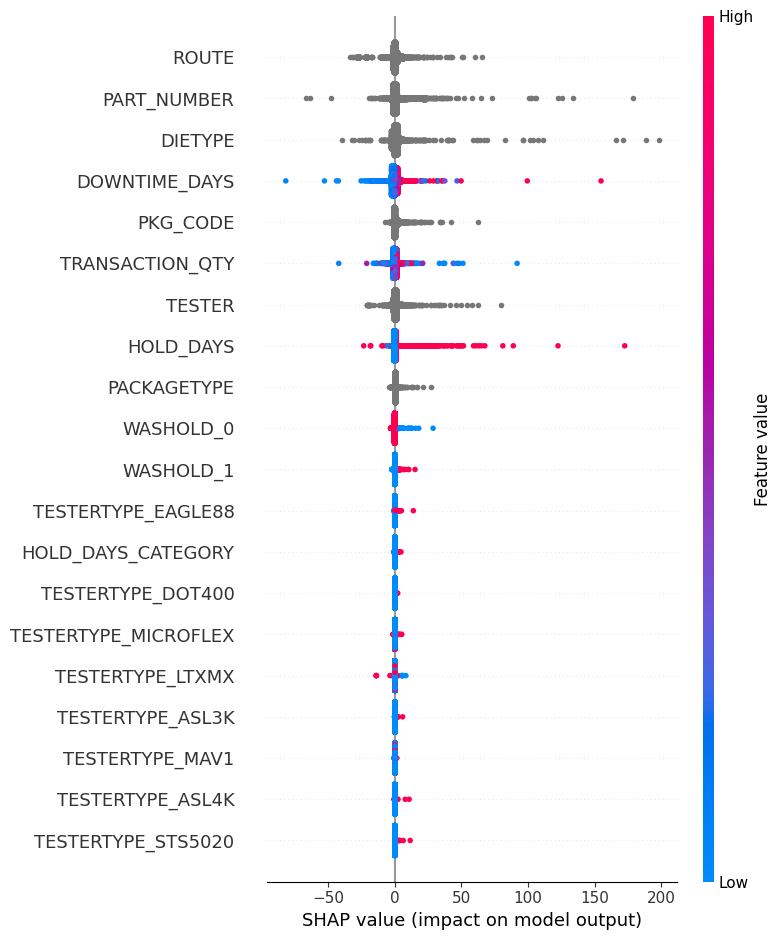

In [81]:
from joblib import load
import shap
import matplotlib.pyplot as plt


model_xgb = load('xgboost_model.pkl')
# Initialize the JS visualization in the notebook (only for Jupyter environments; skip otherwise)
shap.initjs()

# Create a SHAP explainer object
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X)



In [42]:
from sklearn.model_selection import cross_val_score, KFold
# Initialize XGBoost model with best parameters
best_params_lgbm = {'num_leaves': 120, 'learning_rate': 0.019054657412190056, 'n_estimators': 201, 'max_bin': 46, 'bagging_fraction': 0.6743734897831135, 'bagging_freq': 2, 'feature_fraction': 0.8984122708261087, 'min_data_in_leaf': 36, 'min_sum_hessian_in_leaf': 84.00072081453929}
model = lgb.LGBMRegressor(**best_params_lgbm)

# Define a 5-fold cross-validation configuration
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation and calculate the mean absolute error
# Replace 'neg_median_absolute_error' with another scoring metric if desired
scores = cross_val_score(model, X, y, scoring='neg_median_absolute_error', cv=kf, n_jobs=-1)

# Convert scores to positive; cross_val_score returns negative values for 'neg_*' metrics to maximize them
median_absolute_errors = -scores

print(f"Median Absolute Errors for each fold: {median_absolute_errors}")
print(f"Mean Median Absolute Error: {np.mean(median_absolute_errors)}")

Median Absolute Errors for each fold: [0.96101048 0.92015375 0.90203887 0.8894541  0.9663971 ]
Mean Median Absolute Error: 0.9278108586661572


In [163]:
from joblib import dump
model = lgb.LGBMRegressor(**best_params_lgbm)
model.fit(X,y)
# Save the model to a file
dump(model, 'lightgbm_model.pkl')

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8984122708261087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8984122708261087
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=84.00072081453929, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=84.00072081453929
[LightGBM] [Warning] bagging_fraction is set=0.6743734897831135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6743734897831135
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 

['lightgbm_model.pkl']

In [119]:
from joblib import dump

# Save the model to a file
dump(model, 'lgbm_model.pkl')


['lgbm_model.pkl']

## Inference


In [21]:
from joblib import load
import random
# Assuming X_test and y_test are defined and are pandas DataFrame and Series respectively
t = random.randint(0, int(X_test.shape[0]) - 1)  # Ensure t is within the range of indices
sample_input = X_test.iloc[t:t+1]
sample_output = y_test.iloc[t:t+1]
print(list(sample_input.columns))
# Correct way to access the value
print(f"Expected Output: [{sample_output.values[0]}]")

# sample_row = X_test.iloc[0:1]
# Load the model from the file
model_l = load('xgboost_model.pkl')
y_pred = model_l.predict(sample_input)
# y_pred = model_l.predict(sample_row)

print(f"Predicted Output: {y_pred}")



['PART_NUMBER', 'TRANSACTION_QTY', 'ROUTE', 'HOLD_DAYS', 'PKG_CODE', 'TESTER', 'DIETYPE', 'PACKAGETYPE', 'DOWNTIME_DAYS', 'WASHOLD_0', 'WASHOLD_1', 'TESTERTYPE_ASL1K', 'TESTERTYPE_ASL3K', 'TESTERTYPE_ASL4K', 'TESTERTYPE_DOT400', 'TESTERTYPE_DUO', 'TESTERTYPE_EAGLE88', 'TESTERTYPE_HP', 'TESTERTYPE_KTS', 'TESTERTYPE_KVDM2', 'TESTERTYPE_LTX', 'TESTERTYPE_LTXMX', 'TESTERTYPE_MAV1', 'TESTERTYPE_MAV2', 'TESTERTYPE_MICROFLEX', 'TESTERTYPE_NOISE', 'TESTERTYPE_QUARTET', 'TESTERTYPE_RFX', 'TESTERTYPE_SC212', 'TESTERTYPE_STS5020', 'TESTERTYPE_SZ', 'TESTERTYPE_TERA360Z', 'TESTERTYPE_TERCAT', 'TESTERTYPE_TERFLEX', 'TESTERTYPE_TERJ750', 'TESTERTYPE_TERMAG2', 'HOLD_DAYS_CATEGORY']
Expected Output: [2.3398]
Predicted Output: [2.1513898]


In [ ]:
data = ['MAX1452CAE+C8H', 30400, '4_SPH_C_WIP', 0.0, 'A16+2', 'LTX019',
       'SC02Y-1Z', 'SSOP', 0.310497685, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
       